# Step 1: Imports and Environment Setup
This first block imports all the necessary libraries we'll need throughout the project (TensorFlow, Keras, OS utilities, plotting tools, etc.) and verifies the TensorFlow version.

In [2]:
# Block 1: Imports and Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import zipfile
import requests # For downloading
import shutil   # For potential directory adjustments
import numpy as np
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

# Check if GPU is available (Optional but good practice in Colab)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU available: {gpu_devices}")
    # Optional: Configure GPU memory growth to avoid allocating all memory at once
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth configured.")
    except RuntimeError as e:
        print(f"Could not set memory growth: {e}")
else:
    print("GPU not available, running on CPU.")

print("\nSetup Complete. Libraries imported.")

TensorFlow Version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth configured.

Setup Complete. Libraries imported.


# Step 2: Define Constants and Configuration
This block sets up important configuration parameters for image processing and model training.


In [3]:
# Block 2: Define Configuration Parameters
import os # Keep os import if not already run in block 1

# Image parameters
IMG_HEIGHT = 150 # Target image height in pixels
IMG_WIDTH = 150  # Target image width in pixels
CHANNELS = 3     # Number of color channels (usually 3 for CNNs, even if input is grayscale)

# Training parameters
BATCH_SIZE = 32  # Number of images processed in each batch during training
EPOCHS = 50      # Maximum number of training cycles (can be stopped early by callbacks)
NUM_CLASSES = 2  # We have two classes: Positif and Negatif

print("--- Configuration ---")
print(f"Target Image Size: ({IMG_HEIGHT}, {IMG_WIDTH}, {CHANNELS})")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")
print(f"Number of Classes: {NUM_CLASSES}")

--- Configuration ---
Target Image Size: (150, 150, 3)
Batch Size: 32
Max Epochs: 50
Number of Classes: 2


# Step 3: Mount Google Drive and Define Data Paths
This block connects your Google Drive, defines the specific path to your COVID-19 dataset folder based on the location you provided, and sets up paths for creating the train/test split in the Colab environment.

In [4]:
# Block 3: Mount Google Drive and Define Data Paths

from google.colab import drive
import os
import shutil # Will be used in the next step

# Mount Google Drive - You'll likely need to authorize this
drive.mount('/content/drive')

# --- Path to your dataset folder within Google Drive ---
# Updated based on your provided location:
GOOGLE_DRIVE_DATASET_PATH = '/content/drive/MyDrive/Semester 4/2402 - Computer Vision and Image Analysis/Tugas 2/COVID-19' # <--- Specific path provided by user

# --- Paths for the train/test split we will create in Colab's temporary storage ---
BASE_SPLIT_DIR = '/content/covid_data_split' # Directory for split data in Colab
TRAIN_DIR = os.path.join(BASE_SPLIT_DIR, 'train')
TEST_DIR = os.path.join(BASE_SPLIT_DIR, 'test')

# Class names (MUST match the folder names inside the GOOGLE_DRIVE_DATASET_PATH folder EXACTLY)
CLASS_NAMES = ['Negatif', 'Positif'] # Based on user info

# --- Verify the Google Drive path ---
print("--- Verifying Google Drive Path ---")
if not os.path.exists(GOOGLE_DRIVE_DATASET_PATH):
    print(f"ERROR: The specified Google Drive path does not exist:")
    print(f"'{GOOGLE_DRIVE_DATASET_PATH}'")
    print("Please double-check the path and ensure Drive is mounted correctly.")
    # Optional: list contents of parent directory to help find it
    parent_dir = os.path.dirname(GOOGLE_DRIVE_DATASET_PATH)
    print(f"\nAttempting to list contents of parent directory: {parent_dir}")
    try:
        for item in os.listdir(parent_dir):
            print(f"- {item}")
    except FileNotFoundError:
        print(f"Could not list parent directory contents. Path issue likely earlier.")
    except Exception as e:
         print(f"Error listing parent directory: {e}")

else:
    print(f"Google Drive Path found: {GOOGLE_DRIVE_DATASET_PATH}")
    print("\nContents of the dataset folder:")
    found_classes = []
    try:
        for item in os.listdir(GOOGLE_DRIVE_DATASET_PATH):
            item_path = os.path.join(GOOGLE_DRIVE_DATASET_PATH, item)
            if os.path.isdir(item_path):
                 print(f"- {item} (Directory)")
                 found_classes.append(item)
            else:
                 print(f"- {item} (File)") # Should show source.txt here

        # Check if found directories match expected CLASS_NAMES
        if sorted(found_classes) == sorted(CLASS_NAMES):
            print("\nFound directories match expected CLASS_NAMES.")
        else:
            print(f"\nWARNING: Found directories {found_classes} do not exactly match expected CLASS_NAMES {CLASS_NAMES}.")
            print("Check spelling and capitalization in the CLASS_NAMES list and your actual folder names.")

    except Exception as e:
        print(f"Could not list contents of dataset folder: {e}")


# --- Report final paths for Colab environment ---
print(f"\nTrain directory will be created at: {TRAIN_DIR}")
print(f"Test directory will be created at: {TEST_DIR}")

Mounted at /content/drive
--- Verifying Google Drive Path ---
Google Drive Path found: /content/drive/MyDrive/Semester 4/2402 - Computer Vision and Image Analysis/Tugas 2/COVID-19

Contents of the dataset folder:
- Sources.txt (File)
- Negatif (Directory)
- Positif (Directory)

Found directories match expected CLASS_NAMES.

Train directory will be created at: /content/covid_data_split/train
Test directory will be created at: /content/covid_data_split/test


# Step 4: Split Data into Training and Testing Sets
This block defines and runs a function to:


1.   Create the necessary train and test directories (and their class subdirectories) in the Colab environment.
2.   Iterate through the 'Negatif' and 'Positif' folders in your Google Drive dataset.
3.   Randomly split the images within each class (e.g., 80% for training, 20% for testing).
4.   Copy the files to the corresponding train or test subdirectories we just created in Colab. This avoids constantly reading from Google Drive during training, which can be slow.





In [5]:
# Block 4: Split Data into Training and Testing Sets

import random
import math
import glob # To find image files easily

def split_data(source_dir, train_dir, test_dir, class_names, split_ratio=0.8):
    """
    Splits data from source directories into training and testing sets.

    Args:
        source_dir (str): Path to the main dataset directory (e.g., in Google Drive).
        train_dir (str): Path to the target training directory (in Colab).
        test_dir (str): Path to the target testing directory (in Colab).
        class_names (list): List of subdirectories representing classes.
        split_ratio (float): Proportion of data to use for training (default 0.8 for 80%).
    """
    print(f"--- Starting Data Split (Ratio: {split_ratio*100:.0f}% train / {(1-split_ratio)*100:.0f}% test) ---")

    # Remove existing split directories if they exist, for a clean start
    if os.path.exists(os.path.dirname(train_dir)): # Checks if BASE_SPLIT_DIR exists
        print(f"Removing existing split directory: {os.path.dirname(train_dir)}")
        shutil.rmtree(os.path.dirname(train_dir))

    # Create train and test directories and their class subdirectories
    print("Creating train/test directory structure...")
    for d in [train_dir, test_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(d, class_name), exist_ok=True)
            # print(f"  Created: {os.path.join(d, class_name)}") # Uncomment for verbose creation log

    # Process each class
    for class_name in class_names:
        print(f"\nProcessing class: {class_name}")
        source_class_dir = os.path.join(source_dir, class_name)

        # Find all image files (adjust patterns if needed for different extensions)
        image_files = []
        for ext in ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.gif"]: # Add other extensions if necessary
             image_files.extend(glob.glob(os.path.join(source_class_dir, ext)))

        if not image_files:
            print(f"  Warning: No image files found in {source_class_dir} with specified extensions.")
            continue

        print(f"  Found {len(image_files)} images.")

        # Shuffle the files randomly
        random.shuffle(image_files)

        # Calculate split point
        split_point = math.ceil(len(image_files) * split_ratio) # Use ceil to ensure test set isn't overly small

        # Get train and test file lists
        train_files = image_files[:split_point]
        test_files = image_files[split_point:]

        print(f"  Splitting into {len(train_files)} train and {len(test_files)} test images.")

        # Copy files to train directory
        dest_train_class_dir = os.path.join(train_dir, class_name)
        for f in train_files:
            shutil.copy(f, dest_train_class_dir)

        # Copy files to test directory
        dest_test_class_dir = os.path.join(test_dir, class_name)
        for f in test_files:
            shutil.copy(f, dest_test_class_dir)

    print("\n--- Data Split Complete ---")

# --- Execute the split ---
# Using the paths defined in Block 3
split_data(source_dir=GOOGLE_DRIVE_DATASET_PATH,
           train_dir=TRAIN_DIR,
           test_dir=TEST_DIR,
           class_names=CLASS_NAMES,
           split_ratio=0.8) # Using an 80/20 split

# --- Verify the split by counting files ---
print("\n--- Verifying Split Counts ---")
for dir_path in [TRAIN_DIR, TEST_DIR]:
    print(f"Directory: {dir_path}")
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(dir_path, class_name)
        count = len(os.listdir(class_dir))
        print(f"  Class '{class_name}': {count} images")

--- Starting Data Split (Ratio: 80% train / 20% test) ---
Creating train/test directory structure...

Processing class: Negatif
  Found 98 images.
  Splitting into 79 train and 19 test images.

Processing class: Positif
  Found 58 images.
  Splitting into 47 train and 11 test images.

--- Data Split Complete ---

--- Verifying Split Counts ---
Directory: /content/covid_data_split/train
  Class 'Negatif': 79 images
  Class 'Positif': 47 images
Directory: /content/covid_data_split/test
  Class 'Negatif': 19 images
  Class 'Positif': 11 images


# Step 5: Prepare Data Generators
This block creates ImageDataGenerator instances. The training generator will apply data augmentation techniques on-the-fly, while the test generator will only rescale the images. These generators will read images from the train and test directories we just created.

In [6]:
# Block 5: Prepare Data Generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("--- Setting up Data Generators ---")

# --- Training Data Generator with Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.15,    # Randomly shift images horizontally by up to 15% of width
    height_shift_range=0.15,   # Randomly shift images vertically by up to 15% of height
    shear_range=0.15,          # Apply shear transformations
    zoom_range=0.15,           # Randomly zoom in by up to 15%
    horizontal_flip=True,      # Randomly flip images horizontally (often okay for chest X-rays)
    # vertical_flip=False,     # Usually not appropriate for chest X-rays
    fill_mode='nearest'        # How to fill pixels created by shifts/rotations
)

# --- Testing Data Generator (only rescaling) ---
# IMPORTANT: No augmentation for test/validation data!
test_datagen = ImageDataGenerator(
    rescale=1./255             # Only normalize pixel values
)


# --- Create Generators from Directories ---
print("\nCreating Training Generator...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,                  # Path to training data in Colab env
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize images to target dimensions
    batch_size=BATCH_SIZE,
    class_mode='binary',        # For 2 classes (Negatif/Positif) -> outputs 0 or 1
    classes=CLASS_NAMES,        # Explicitly set class order if needed (optional here as names match)
    shuffle=True                # Shuffle training data each epoch
)

print("\nCreating Testing Generator...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,                   # Path to testing data in Colab env
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,      # Can use same or different batch size for testing
    class_mode='binary',
    classes=CLASS_NAMES,
    shuffle=False               # DO NOT shuffle test data for consistent evaluation
)

# --- Verify Class Indices ---
# Check which label (Negatif/Positif) corresponds to 0 and 1
print("\n--- Verification ---")
print(f"Training Generator - Class Indices: {train_generator.class_indices}")
print(f"Testing Generator  - Class Indices: {test_generator.class_indices}")

# Calculate steps per epoch for training and validation
# Ensure we cover all images, rounding up if necessary
train_steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
test_steps_per_epoch = math.ceil(test_generator.samples / BATCH_SIZE)

print(f"Total Training Images: {train_generator.samples}")
print(f"Total Testing Images: {test_generator.samples}")
print(f"Training Steps per Epoch: {train_steps_per_epoch}")
print(f"Testing Steps per Epoch: {test_steps_per_epoch}")

--- Setting up Data Generators ---

Creating Training Generator...
Found 126 images belonging to 2 classes.

Creating Testing Generator...
Found 30 images belonging to 2 classes.

--- Verification ---
Training Generator - Class Indices: {'Negatif': 0, 'Positif': 1}
Testing Generator  - Class Indices: {'Negatif': 0, 'Positif': 1}
Total Training Images: 126
Total Testing Images: 30
Training Steps per Epoch: 4
Testing Steps per Epoch: 1


# Step 6: Build the CNN Model
This block defines the architecture of our CNN using the Keras Sequential API. It stacks Convolutional layers (to extract features), Batch Normalization (to stabilize training), MaxPooling layers (to downsample), and Dense layers (for classification). Dropout is included for regularization.

In [7]:
# Block 6: Build the CNN Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

print("--- Building the CNN Model ---")

model = Sequential(name="COVID_XRay_Classifier") # Give the model a name

# Input Layer + First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), name='conv1_1'))
model.add(BatchNormalization(name='bn1_1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
# Output shape after pool1: Roughly (IMG_HEIGHT/2, IMG_WIDTH/2, 32)

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1')) # 'same' padding keeps spatial dims
model.add(BatchNormalization(name='bn2_1'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2')) # Optional extra conv layer
# model.add(BatchNormalization(name='bn2_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
# Output shape after pool2: Roughly (IMG_HEIGHT/4, IMG_WIDTH/4, 64)

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'))
model.add(BatchNormalization(name='bn3_1'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2')) # Optional extra conv layer
# model.add(BatchNormalization(name='bn3_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
# Output shape after pool3: Roughly (IMG_HEIGHT/8, IMG_WIDTH/8, 128)

# Flattening the feature maps
model.add(Flatten(name='flatten'))
# Output shape: (IMG_HEIGHT/8 * IMG_WIDTH/8 * 128) neurons

# Fully Connected Layers (Dense)
model.add(Dense(256, activation='relu', name='dense1')) # Increased capacity Dense layer
model.add(BatchNormalization(name='bn_dense1'))         # BN before dropout can sometimes be better
model.add(Dropout(0.5, name='dropout1'))                 # Dropout for regularization (0.5 is common)

# Output Layer
# Single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid', name='output'))

# --- Display Model Summary ---
print("\n--- Model Summary ---")
model.summary()

--- Building the CNN Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Model Summary ---


Model: "COVID_XRay_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 148, 148, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 74, 74, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 37, 37, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,712,513 (40.86 MB)

 Trainable params: 10,711,553 (40.86 MB)

 Non-trainable params: 960 (3.75 KB)

# Step 7: Compile the Model
This step configures the model for training by specifying the optimizer, the loss function, and the metrics to track.

In [9]:
# Block 7: Compile the Model

print("--- Compiling the Model ---")

# Define the optimizer (Adam is a good default choice)
# A slightly lower learning rate can sometimes be beneficial for stability
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) # Experiment with learning rate (e.g., 0.001, 0.0001)

# Define the loss function for binary classification
loss_function = 'binary_crossentropy'

# Define metrics to evaluate during training and testing
metrics_to_track = ['accuracy'] # Can add others like Precision, Recall, AUC later

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics_to_track)

print("Model compiled successfully.")
print(f"  Optimizer: {type(optimizer).__name__} (lr={optimizer.learning_rate.numpy():.1E})") # Shows actual LR
print(f"  Loss Function: {loss_function}")
print(f"  Metrics: {metrics_to_track}")

--- Compiling the Model ---
Model compiled successfully.
  Optimizer: Adam (lr=5.0E-04)
  Loss Function: binary_crossentropy
  Metrics: ['accuracy']


# Step 8: Define Callbacks
Callbacks are utilities that can be applied at certain stages of the model training process (e.g., at the end of each epoch). We'll use two common ones:

*   EarlyStopping: To stop training automatically if the model's performance on the validation set stops improving, preventing overfitting and saving time.
*   ReduceLROnPlateau: To automatically reduce the learning rate if the validation loss plateaus, which can help the model find a better minimum.






In [10]:
# Block 8: Define Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("--- Defining Callbacks ---")

# Early Stopping: Stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped.
    verbose=1,           # Print messages when stopping
    restore_best_weights=True # Restore model weights from the epoch with the best val_loss.
)

# Reduce Learning Rate on Plateau: Reduce LR when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,          # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,           # Print messages when reducing LR
    min_lr=1e-6          # Lower bound on the learning rate.
)

# Combine callbacks into a list
callbacks_list = [early_stopping, reduce_lr]

print("Callbacks defined:")
print(f"- EarlyStopping (monitor='val_loss', patience={early_stopping.patience})")
print(f"- ReduceLROnPlateau (monitor='val_loss', patience={reduce_lr.patience}, factor={reduce_lr.factor})")

--- Defining Callbacks ---
Callbacks defined:
- EarlyStopping (monitor='val_loss', patience=10)
- ReduceLROnPlateau (monitor='val_loss', patience=5, factor=0.2)


# Step 9: Train the Model
This block starts the training process using the model.fit() method. We provide the training data generator, specify the number of epochs, provide the validation data generator, and include the callbacks we just defined. The training history (loss and accuracy over epochs) will be stored.

In [11]:
# Block 9: Train the Model

print("--- Starting Model Training ---")

# Train the model using the generators and callbacks
history = model.fit(
    train_generator,
    epochs=EPOCHS,                      # Maximum number of epochs (defined in Block 2)
    steps_per_epoch=train_steps_per_epoch, # Batches per training epoch (calculated in Block 5)
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch, # Batches per validation epoch (calculated in Block 5)
    callbacks=callbacks_list            # List of callbacks (EarlyStopping, ReduceLROnPlateau)
)

print("\n--- Model Training Finished ---")

# Optional: Display the range of epochs actually run
final_epoch = len(history.history['loss'])
print(f"Training stopped after {final_epoch} epochs.")

--- Starting Model Training ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4710 - loss: 1.6700 - val_accuracy: 0.6333 - val_loss: 0.6685 - learning_rate: 5.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5969 - loss: 1.0944 - val_accuracy: 0.5333 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6378 - loss: 0.9768 - val_accuracy: 0.4000 - val_loss: 0.7087 - learning_rate: 5.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5969 - loss: 1.0691 - val_accuracy: 0.6000 - val_loss: 0.6783 - learning_rate: 5.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6490 - loss: 0.8680 - val_accuracy: 0.6333 - val_loss: 0.6547 - learning_rate: 5.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5950 - loss: 0.9803 - val_accuracy: 0.6667 - val_loss: 0.6414 - learning_rate: 5.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6102 - loss: 0.6945 - val_accura

# Step 10: Evaluate the Model and Plot History
This block evaluates the final model (with weights restored from the best epoch) on the test set and then plots the training/validation accuracy and loss curves from the history object.

--- Evaluating Model on Test Set ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6667 - loss: 0.6390

Test Loss: 0.6390
Test Accuracy: 66.67%

--- Plotting Training History ---


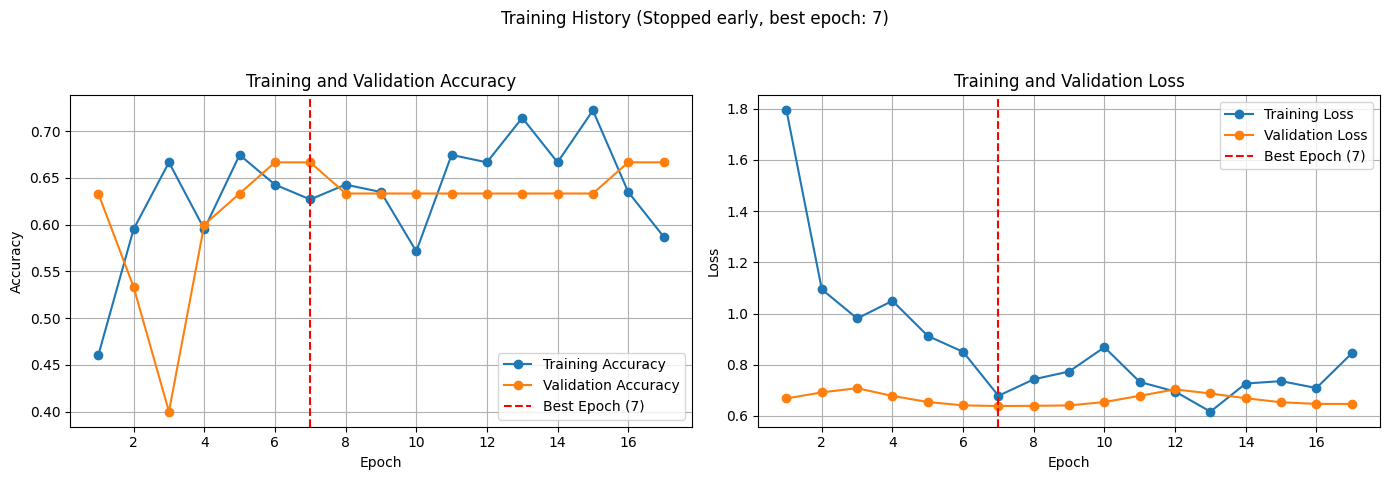

In [12]:
# Block 10: Evaluate the Model and Plot History

import matplotlib.pyplot as plt

print("--- Evaluating Model on Test Set ---")

# Evaluate the model on the test generator
# Uses the weights restored by EarlyStopping from the best epoch
loss, accuracy = model.evaluate(test_generator,
                                steps=test_steps_per_epoch, # Ensure evaluation covers the whole test set
                                verbose=1)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%") # Should match the best val_accuracy if restore_best_weights worked


print("\n--- Plotting Training History ---")

def plot_history(history):
    """Plots accuracy and loss curves for training and validation."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1) # Start epoch range from 1

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'o-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy')
    plt.axvline(early_stopping.best_epoch + 1, color='r', linestyle='--', label=f'Best Epoch ({early_stopping.best_epoch + 1})') # Add 1 because epoch count is 1-based
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'o-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss')
    plt.axvline(early_stopping.best_epoch + 1, color='r', linestyle='--', label=f'Best Epoch ({early_stopping.best_epoch + 1})')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.suptitle(f'Training History (Stopped early, best epoch: {early_stopping.best_epoch + 1})')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Plot the history returned by model.fit()
plot_history(history)